# Распознавание фруктов с помощью сверточной нейрнной сети

## Импорт библиотек

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers
from keras import models
import os
import shutil
%matplotlib inline 

## Загружаем данные

**Подключение к Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Копируем файл в сессионное хранилище**

In [ ]:
# Копируем наш архив
# !cp[пробел][директория источник][пробел][целевая директория]
!cp /content/drive/'My Drive'/fruits-360.zip /

**Возвращаемся в сессионое хранилище**

In [ ]:
%cd /
!ls


/
bin	 dev		 lib	mnt	    root  sys		     usr
boot	 etc		 lib32	opt	    run   tensorflow-1.15.2  var
content  fruits-360.zip  lib64	proc	    sbin  tmp
datalab  home		 media	python-apt  srv   tools


**Разархивируем датасет**

In [ ]:
!unzip -q /fruits-360.zip

In [ ]:
%cd /
!ls

/
bin	 dev		 home	media  python-apt  srv		      tools
boot	 etc		 lib	mnt    root	   sys		      usr
content  fruits-360	 lib32	opt    run	   tensorflow-1.15.2  var
datalab  fruits-360.zip  lib64	proc   sbin	   tmp


In [ ]:
!cp /content/drive/'My Drive'/test.zip /fruits-360
%cd /fruits-360
!rm -rf test
!unzip -q /fruits-360/test.zip
!ls

/fruits-360
test  test.zip	train  validation


## Формирование датасета

**Создаем нужные директории**

In [ ]:
# Каталог для выделенного набора
base_dir = '/fruits-360'

# Каталоги для обучающего, проверочного и контрольного поднаборов
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print('total training class:', len(os.listdir(train_dir)))
print('total validation class:', len(os.listdir(validation_dir)))
print('total test images:', len(os.listdir(test_dir)))

total training class: 131
total validation class: 131
total test images: 1


In [ ]:
%cd /fruits-360/test/
!ls

/fruits-360/test
test


## Конструируем сеть

**Создаем модель**

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
 input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(131, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

**Компилируем сеть**

In [ ]:
# Настройка модели для обучения
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])



**Предварительная обработка**  
  
В процессе будет необходимо преобразовать JPEG в RGB, а затем преобразовать содержимое в тензоры с вещественными числами.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Масштабируем изображения с коэффициентом 1/255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir, # Целевой каталог
    target_size=(150, 150), # Привести все изображения к размеру 150 на 150
    batch_size=200,
    class_mode='categorical') # Так как используется функция потерь 
                         # binary_crossentropy, метки должны быть бинарными

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='categorical')

# Создаим генератор, с помощью которого будем передавать данные в модель
for data_batch, labels_batch in train_generator:
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break
        

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.
data batch shape: (200, 150, 150, 3)
labels batch shape: (200, 131)


## Обучаем

**Обучение с использованием генератора**

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=338,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=226)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
338/338 [==============================] - 130s 345ms/step - loss: 0.4654 - accuracy: 0.8852 - val_loss: 0.2344 - val_accuracy: 0.9364
Epoch 2/30
338/338 [==============================] - 133s 392ms/step - loss: 0.0416 - accuracy: 0.9879 - val_loss: 0.2322 - val_accuracy: 0.9483
Epoch 3/30
338/338 [==============================] - 114s 336ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.1866 - val_accuracy: 0.9606
Epoch 4/30
338/338 [==============================] - 113s 335ms/step - loss: 0.0209 - accuracy: 0.9942 - val_loss: 0.2326 - val_accuracy: 0.9454
Epoch 5/30
338/338 [==============================] - 114s 336ms/step - loss: 0.0128 - accuracy: 0.9966 - val_loss: 0.2421 - val_accuracy: 0.9536
Epoch 6/30
338/338 [==============================] - 113s 334ms/step - loss: 0.0225 - accuracy: 0.9938 - val_loss: 0.1495 - val_accuracy: 0.9729
Epoch 7/30
338/338 [==============================] - 113s 334ms/step - loss: 1.5397e-04 - accuracy: 0.9999 - val_loss: 0.15

**Выведем график**

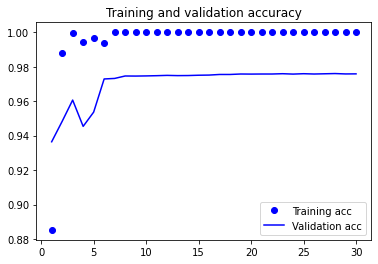

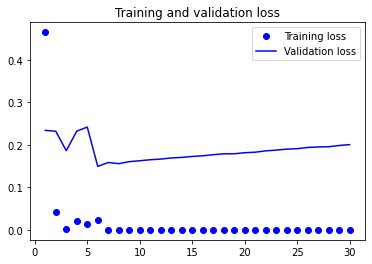

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

prediction = model.predict(test_generator)

for i in prediction:
    print(i)

Found 103 images belonging to 1 classes.
[8.34929723e-18 1.21492031e-20 4.69354102e-13 2.66367614e-12
 2.24334897e-15 6.69835047e-22 1.04598684e-17 5.66576315e-15
 3.43683622e-24 1.27446612e-18 1.03527527e-12 9.14200356e-14
 9.30423796e-01 1.32872810e-25 7.04335848e-23 1.48661494e-22
 3.95353056e-11 3.13721632e-10 1.23611340e-13 5.57260130e-17
 9.05235120e-21 4.58187627e-10 2.76533505e-12 1.83137232e-16
 1.69842735e-08 6.00555763e-02 7.93096329e-14 1.11278983e-23
 5.79277627e-17 2.48497541e-19 3.43485529e-18 8.31153664e-20
 8.83298290e-20 9.96588029e-19 6.39353715e-22 2.09443352e-10
 4.05802076e-08 9.73455094e-09 4.48591265e-19 2.47158756e-20
 7.30394217e-12 9.58289732e-17 1.10521037e-09 1.28334341e-13
 1.75815171e-17 8.75008402e-19 1.40793120e-18 1.42598268e-13
 2.32477340e-14 1.54664205e-12 1.03534460e-23 4.27118166e-23
 1.28249679e-13 3.58188825e-19 6.14163473e-17 3.59797123e-16
 2.36213137e-21 6.20379970e-09 4.34767991e-19 2.45298409e-17
 2.44007424e-19 1.24316070e-11 6.65278176e-1

In [ ]:

for i in prediction:
    print(np.argmax(i))

12
113
37
95
37
95
17
37
37
17
116
95
37
39
37
25
116
37
17
24
37
37
17
37
37
37
93
37
37
101
121
37
95
37
37
130
37
37
116
116
37
93
17
95
95
17
113
37
93
95
116
37
37
17
17
113
37
130
17
37
37
93
113
25
93
37
17
37
12
95
113
17
17
37
17
37
37
121
17
116
37
93
37
17
130
101
95
37
37
24
37
101
17
17
12
37
37
130
37
37
37
37
130


## Расширение данных

In [ ]:
# Настройка расширения данных
datagen = ImageDataGenerator(
    rotation_range=40, # случайны поворот картинки
    width_shift_range=0.2, # диапазон смещения по ширине
    height_shift_range=0.2, # и по высоте
    shear_range=0.2, # сдвиговое преобразование
    zoom_range=0.2, # масштаб
    horizontal_flip=True, # переворачивание половины изображения
    fill_mode='nearest') # стратегия заполнения новых пикселов,
                         # которые появились после поворота или
                         # смещения

## Конструируем новую сеть

In [ ]:
# Новая сеть со слоем прореживания
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(131, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
# Обучение сети с использованием генератора расширения данных
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # Целевой каталог
    target_size=(150, 150), # Привести все изображения к размеру 150 на 150
    batch_size=200,
    class_mode='categorical') 

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='categorical')

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=33,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=226)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
33/33 [==============================] - 63s 2s/step - loss: 4.4193 - accuracy: 0.0414 - val_loss: 3.4495 - val_accuracy: 0.1239
Epoch 2/30
33/33 [==============================] - 63s 2s/step - loss: 3.0213 - accuracy: 0.1795 - val_loss: 2.4648 - val_accuracy: 0.2948
Epoch 3/30
33/33 [==============================] - 62s 2s/step - loss: 2.1300 - accuracy: 0.3671 - val_loss: 1.7342 - val_accuracy: 0.4948
Epoch 4/30
33/33 [==============================] - 82s 3s/step - loss: 1.5912 - accuracy: 0.5059 - val_loss: 1.2462 - val_accuracy: 0.6192
Epoch 5/30
33/33 [==============================] - 65s 2s/step - loss: 1.1975 - accuracy: 0.6176 - val_loss: 0.8522 - val_accuracy: 0.7426
Epoch 6/30
33/33 [==============================] - 65s 2s/step - loss: 0.8443 - accuracy: 0.7286 - val_loss: 0.7190 - val_accuracy: 0.7923
Epoch 7/30
33/33 [==============================] - 64s 2s/step - loss: 0.6887 - accuracy: 0.7745 - val_loss: 0.6831 - val_accuracy: 0.8056
Epoch 8/30
33/33 [==

**Выводим график**

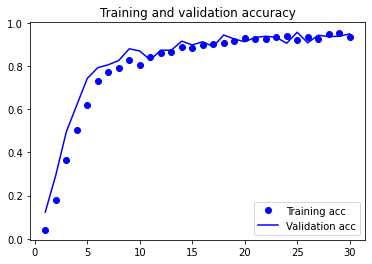

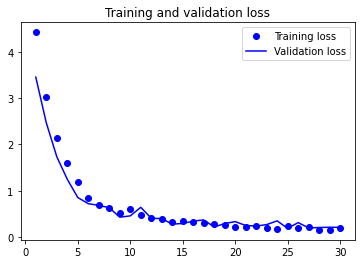

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

prediction = model.predict(test_generator)

for i in prediction:
    print(np.argmax(i))

Found 103 images belonging to 1 classes.
14
12
66
37
37
37
37
37
25
37
37
14
37
4
11
7
37
37
37
12
37
24
11
26
116
9
45
12
37
14
116
21
18
9
37
45
12
18
37
24
116
25
24
37
37
37
116
14
7
99
13
37
66
39
24
25
12
66
14
39
37
12
25
37
87
37
130
7
25
14
116
21
66
24
12
37
24
11
24
13
37
24
12
25
25
24
11
12
37
37
7
37
4
12
14
24
14
66
116
26
14
66
12


In [ ]:
!ls

test
